import statements

In [3]:
import pandas as pd
import requests
import gzip
import io
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

data download

In [4]:
rnaseq_url = "https://linkedomics.org/data_download/TCGA-LAML/Human__TCGA_LAML__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct.gz"
response = requests.get(rnaseq_url)
compressed_file = io.BytesIO(response.content)
with gzip.open(compressed_file, 'rb') as f:
    rnaseq_data = pd.read_csv(f, sep='\t', index_col=0).T
rnaseq_data.index = rnaseq_data.index.str.replace(r'\.', '-', regex=True)

methyl_url = "https://linkedomics.org/data_download/TCGA-LAML/Human__TCGA_LAML__JHU_USC__Methylation__Meth450__01_28_2016__BI__Gene__Firehose_Methylation_Prepocessor.cct.gz"
methyl_data = pd.read_csv(methyl_url, sep='\t', index_col=0).T
methyl_data.index = methyl_data.index.str.replace(r'\.', '-', regex=True)

mirna_url = "https://linkedomics.org/data_download/TCGA-LAML/Human__TCGA_LAML__BDGSC__miRNASeq__GA_miR__01_28_2016__BI__Gene__Firehose_RPM_log2.cct"
mirna_data = pd.read_csv(mirna_url, sep='\t', index_col=0).T
mirna_data.index = mirna_data.index.str.replace(r'\.', '-', regex=True)

clinical_url = "https://linkedomics.org/data_download/TCGA-LAML/Human__TCGA_LAML__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi"
clinical_data = pd.read_csv(clinical_url, sep='\t', index_col=0).T
clinical_data.index = clinical_data.index.str.replace(r'\.', '-', regex=True)

In [5]:
clinical_data

attrib_name,years_to_birth,gender,race,ethnicity,overall_survival,status,overallsurvival
TCGA-AB-2802,50,male,white,nothispanicorlatino,365,1,"365,1"
TCGA-AB-2803,61,female,white,nothispanicorlatino,792,1,"792,1"
TCGA-AB-2804,30,male,white,nothispanicorlatino,2557,0,"2557,0"
TCGA-AB-2805,77,male,white,nothispanicorlatino,577,1,"577,1"
TCGA-AB-2806,46,male,white,nothispanicorlatino,945,1,"945,1"
...,...,...,...,...,...,...,...
TCGA-AB-3007,35,male,white,nothispanicorlatino,1581,0,"1581,0"
TCGA-AB-3008,22,male,white,nothispanicorlatino,822,1,"822,1"
TCGA-AB-3009,23,male,NaN,NaN,577,1,"577,1"
TCGA-AB-3011,21,female,white,nothispanicorlatino,1885,0,"1885,0"


In [6]:
mirna_data

attrib_name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-AB-2802,13.1738,14.1291,13.1835,15.2912,8.8943,11.1296,8.7513,5.2378,12.3431,11.3358,...,0.0000,3.3956,5.1848,0.0,2.9640,1.2391,1.2391,6.5680,7.7178,10.9616
TCGA-AB-2803,13.3854,14.4086,13.3704,13.1248,6.9594,10.2646,9.2128,6.4006,13.6417,9.5399,...,0.0000,0.9170,3.3047,0.0,0.0000,0.0000,0.9170,6.7130,6.9176,11.5909
TCGA-AB-2805,12.7154,13.6962,12.7219,13.7431,5.9068,11.9603,9.7195,5.7139,12.4446,11.5513,...,1.0515,3.4133,4.6205,0.0,0.0000,0.0000,1.0515,7.7518,3.5517,14.0675
TCGA-AB-2806,12.8114,13.7750,12.8143,13.4309,5.6829,12.4028,9.0939,5.7615,12.7165,11.6729,...,1.2864,3.6454,6.4955,0.0,1.2864,0.0000,0.0000,6.8596,2.4107,13.0672
TCGA-AB-2807,13.2307,14.2272,13.2420,14.3734,13.1471,11.7190,10.3149,6.3596,12.9213,12.2088,...,1.3073,3.5013,4.9987,0.0,0.0000,1.3073,0.0000,6.9474,11.1987,14.3708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AB-3007,13.3568,14.4069,13.3400,13.5220,5.9879,12.3048,9.6522,6.0932,13.1629,11.4763,...,2.5373,3.2340,6.1913,0.0,0.0000,1.1383,4.3377,7.0953,6.0415,14.0253
TCGA-AB-3008,12.6734,13.6235,12.6415,13.4769,11.0875,11.6894,8.7958,6.6743,12.8200,12.1279,...,0.0000,4.0495,6.0854,0.0,0.0000,0.0000,4.5098,7.4787,8.7019,11.0657
TCGA-AB-3009,13.0529,14.0127,13.0380,13.6314,6.6393,11.9470,10.1551,7.1910,13.2617,12.4627,...,0.0000,2.4205,5.5680,0.0,0.0000,2.4205,0.0000,7.2880,3.8136,13.9800
TCGA-AB-3011,13.1668,14.1587,13.2009,15.1642,6.2807,11.4396,9.2298,6.1877,12.3385,11.3447,...,0.0000,1.9688,5.1294,0.0,1.5573,0.0000,0.0000,6.2626,2.2887,12.3754


In [9]:
rnaseq_data

attrib_name,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-AB-2803,8.6915,0.0000,0.0,6.1781,1.6124,8.8706,3.6226,0.0000,0.0,9.0096,...,5.0841,8.8222,11.7336,4.0384,10.1151,12.1298,11.2817,10.2295,4.1261,0.0000
TCGA-AB-2805,6.4224,0.0000,0.0,5.6307,2.1199,4.0929,0.7392,1.8787,0.0,9.0601,...,3.7058,8.4801,11.9734,1.8787,10.7940,12.4972,11.9022,10.1635,3.7058,2.6678
TCGA-AB-2806,7.5557,0.0000,0.0,5.6958,2.7503,3.0003,4.2344,1.1847,0.0,8.9805,...,6.0975,9.6910,11.8987,1.5408,9.5511,12.4170,11.8458,10.9260,6.6204,0.0000
TCGA-AB-2807,8.4406,0.0000,0.0,5.5469,0.9949,8.4288,6.8727,2.5766,0.0,9.4473,...,7.2568,9.8323,11.3337,2.5766,10.2379,11.7912,12.0398,10.4463,4.2384,2.9912
TCGA-AB-2808,7.0522,0.0000,0.0,5.5889,2.7002,8.0051,7.5176,0.8363,0.0,8.7971,...,5.3598,8.9878,11.5914,1.3624,10.6285,11.8249,11.4981,10.4849,4.5233,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AB-3007,8.3891,0.0000,0.0,6.0038,2.0704,3.4060,8.0629,0.0000,0.0,9.6077,...,6.8405,9.2616,12.0986,2.7225,9.9753,11.1680,12.1607,10.5238,3.7866,1.7655
TCGA-AB-3008,7.1453,0.0000,0.0,5.1470,2.5257,9.6211,7.3826,0.7483,0.0,9.6496,...,6.8983,9.1040,11.5265,0.0000,10.0500,12.3913,11.9933,10.1741,5.9265,0.0000
TCGA-AB-3009,6.8552,0.9292,0.0,6.7628,4.9466,7.8776,4.1106,0.0000,0.0,9.0813,...,6.5144,9.1655,12.0111,2.6837,10.5094,13.2654,12.2704,10.7065,9.4492,0.0000
TCGA-AB-3011,7.6810,0.0000,0.0,5.0013,1.6620,4.5685,4.8649,1.6620,0.0,9.6335,...,5.6352,8.8586,12.1938,4.1072,10.1611,12.1495,12.1750,10.5662,4.6944,0.0000


Data cleaning/preprocessing

In [7]:
def deep_clean_omics(df, max_na=0.2):
    df = df.apply(pd.to_numeric, errors='coerce')

    na_feature = df.isna().mean(axis=0) <= max_na
    var_feature = df.nunique() > 1 
    good_features = na_feature & var_feature
    df_clean = df.loc[:, good_features]
    
    imputer = lambda x: x.fillna(x.median() if x.notna().any() else 0)
    df_clean = df_clean.apply(imputer, axis=0)

    assert not df_clean.isna().any().any(), f"NaNs remain in {df_clean.shape}"
    return df_clean

rnaseq_clean = deep_clean_omics(rnaseq_data)
methyl_clean = deep_clean_omics(methyl_data).add_prefix('METH_')
mirna_clean = deep_clean_omics(mirna_data).add_prefix('MIR_')

In [12]:
def standardize_index(df):
    df.index = df.index.str.upper().str.replace(r'[^A-Z0-9-]', '-', regex=True)
    return df

rnaseq_clean = standardize_index(rnaseq_clean)
methyl_clean = standardize_index(methyl_clean)
mirna_clean = standardize_index(mirna_clean)
clinical_data = standardize_index(clinical_data)

common_samples = (
    rnaseq_clean.index
    .intersection(methyl_clean.index)
    .intersection(mirna_clean.index)
    .intersection(clinical_data.index)
)

In [16]:
multi_omics = pd.concat([
    rnaseq_clean.loc[common_samples],
    methyl_clean.loc[common_samples],
    mirna_clean.loc[common_samples]
], axis=1)

final_data = multi_omics.merge(
    clinical_data[['overall_survival', 'status']],
    left_index=True,
    right_index=True,
    how='inner'
)

final_data = final_data.dropna()
assert final_data.isna().sum().sum() == 0, f"Final NaNs: {final_data.isna().sum().sum()}"


In [17]:
print("\n=== Data Validation ===")
print(f"RNA-seq: {rnaseq_clean.shape} | Methyl: {methyl_clean.shape} | miRNA: {mirna_clean.shape}")
print(f"Common samples: {len(common_samples)}")
print(f"Final data shape: {final_data.shape}")
print(f"Feature types: RNA={rnaseq_clean.shape[1]} | Methyl={methyl_clean.shape[1]} | miRNA={mirna_clean.shape[1]}")



=== Data Validation ===
RNA-seq: (173, 19448) | Methyl: (194, 20120) | miRNA: (188, 503)
Common samples: 170
Final data shape: (146, 40073)
Feature types: RNA=19448 | Methyl=20120 | miRNA=503


170 common samples - evident from the shape below

In [38]:
common_samples = (
    rnaseq_clean.index
    .intersection(methyl_clean.index)
    .intersection(mirna_clean.index)
    .intersection(clinical_data.index)
)

multi_omics_clean = pd.concat([
    rnaseq_clean.loc[common_samples],
    methyl_clean.loc[common_samples],
    mirna_clean.loc[common_samples]
], axis=1)

print(f"Clean multi-omics shape: {multi_omics_clean.shape}")


Clean multi-omics shape: (170, 40071)


In [39]:
assert not multi_omics_clean.isna().any().any(), "NaNs detected in multi-omics data!"

final_data_clean = multi_omics_clean.merge(
    clinical_data[['overall_survival', 'status']],
    left_index=True,
    right_index=True
)

print(f"Final clean data: {final_data_clean.shape}")
print("Remaining NaNs:", final_data_clean.isna().sum().sum())


Final clean data: (170, 40073)
Remaining NaNs: 48


In [41]:
valid_samples = final_data['overall_survival'].notna()
final_data_clean = final_data[valid_samples]

print(f"Clean dataset shape: {final_data_clean.shape}")

Clean dataset shape: (146, 40073)


FInal clean data has 146 samples

In [42]:
final_data_clean['overall_survival'] = final_data_clean['overall_survival'].astype(float)/365

In [43]:
print(final_data_clean['overall_survival'])

TCGA-AB-2803    2.169863
TCGA-AB-2805    1.580822
TCGA-AB-2806    2.589041
TCGA-AB-2807    0.495890
TCGA-AB-2808    7.838356
                  ...   
TCGA-AB-3007    4.331507
TCGA-AB-3008    2.252055
TCGA-AB-3009    1.580822
TCGA-AB-3011    5.164384
TCGA-AB-3012    5.169863
Name: overall_survival, Length: 146, dtype: float64


In [44]:
X_clean = final_data_clean.drop(['overall_survival', 'status'], axis=1)
y_clean = final_data_clean[['status', 'overall_survival']]
status = final_data_clean['status'].astype(bool)

In [45]:
final_y = np.array(
    list(zip(y_clean["status"], y_clean["overall_survival"])),
    dtype=[("status", bool), ("time", float)]
)

In [46]:
y_clean.loc[:, 'overall_survival'] = y_clean['overall_survival'].astype(np.float32)
y_clean.loc[:, 'status'] = y_clean['status'].astype(bool)

In [47]:
X_clean = X_clean.astype(np.float32)

In [48]:
var_selector = VarianceThreshold(threshold=0.1)
X_filtered = var_selector.fit_transform(X_clean)

selected_by_var = X_clean.columns[var_selector.get_support()]
print(f"Features after variance threshold: {len(selected_by_var)}")

Features after variance threshold: 18615


In [49]:
kbest_selector = SelectKBest(score_func=f_regression, k=500)
X_selected = kbest_selector.fit_transform(X_filtered, y_clean['overall_survival'].astype(float))

In [50]:
final_selected_features = selected_by_var[kbest_selector.get_support()]
print("\nFinal selected features:", len(final_selected_features))
print("Top 5 genes:", final_selected_features[:5].tolist())


Final selected features: 500
Top 5 genes: ['ABCC8', 'ABHD13', 'ABHD8', 'ACBD3', 'ACOT13']


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, final_y, test_size=0.2, random_state=42)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

CoxPHSurvival - method for investigating the effect of several variables upon the time a specified event takes to happen

In [53]:
cox_model = CoxPHSurvivalAnalysis(alpha=1000)  # Increase alpha (default=0)
cox_model.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=1000)

Concordance index 

In [54]:
pred_risk = cox_model.predict(X_test)
result = concordance_index_censored(y_test['status'], y_test['time'], pred_risk)
print(f"C-index: {result[0]:.2f}")

C-index: 0.74


In [55]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

high_risk = pred_risk > np.median(pred_risk)

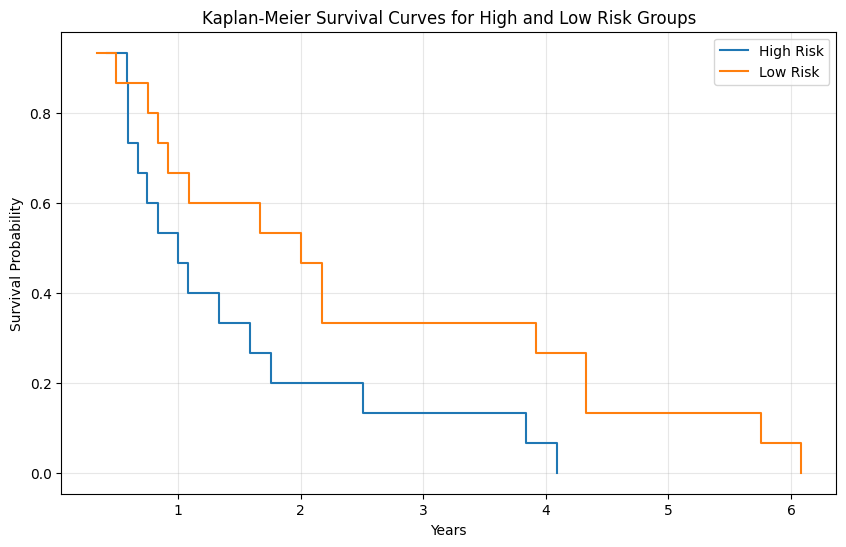

In [56]:
plt.figure(figsize=(10, 6))
for is_high_risk, label in [(True, "High Risk"), (False, "Low Risk")]:
    mask = high_risk == is_high_risk
    time, prob = kaplan_meier_estimator(y_test['status'][mask], y_test['time'][mask])
    plt.step(time, prob, where="post", label=label)

plt.xlabel("Years")
plt.ylabel("Survival Probability")
plt.legend()
plt.title("Kaplan-Meier Survival Curves for High and Low Risk Groups")
plt.grid(True, alpha=0.3)
plt.show()